In [1]:
import sys, os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import smc_samplers as smp
from particles import kalman
from particles import resampling
from particles import mcmc
from particles import rao_blackwell
from particles import plotting_util
import particles
import corner
from math import sqrt, cos, sin, pi
import seaborn as sb
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,  # affects non-LaTeX-rendered text like axis tick labels
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "text.latex.preamble": r"\usepackage{amsmath}\renewcommand{\rmdefault}{cmr}\renewcommand{\sfdefault}{cmss}\renewcommand{\ttdefault}{cmtt}\usepackage{relsize}",
})

np.random.seed(1)


dt = 0.001 # the fine time scale for Euler Maruyama (so that everything is stable)
dt_data = 1. # the time scale at which data is generated in the AC 2d dataset

niter = 5000

length_data = 50 #50, 200
num_particles = 300 #300
num_particles_SMC2 = 1000

Load data

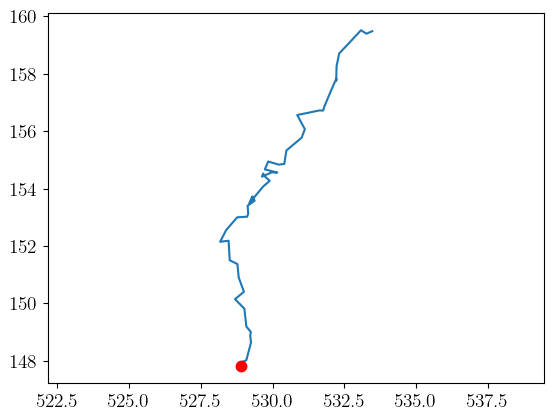

In [2]:
voltage = "4"
number = "4"

data = np.loadtxt(f"..\\particles\\datasets\\Trajectories_AC_2d\\{voltage}Vpp\\{voltage}Vpp{number}.txt")[0:length_data,1:]
ys = data-data[0]
plt.figure()
plt.plot(data[:,0],data[:,1],'-')
plt.plot(data[0,0],data[0,1],'r.', markersize=15)
plt.axis("equal");
plt.savefig(f"data_colloid_{voltage}Vpp{number}_length{length_data}.png", dpi=300)

ABM class (small modification to allow for finer discretisation of numerical scheme than what we have in data)


In [3]:
class ABM(rao_blackwell.RBMVLinearGauss):
    def __init__(self, **kwargs):
        default_parameters = {'D0': 1, 'Drot': 1, 'Dobs': 1}
        self.__dict__.update(default_parameters)
        self.__dict__.update(kwargs)
        num_collate_dt = int(dt_data/dt)  # k
        
        A = lambda w: np.array([[1., 0., num_collate_dt*dt*cos(w)],[0., 1., num_collate_dt*dt*sin(w)],[0.,0.,1.]])
        Gamma = lambda w: np.diag([(num_collate_dt*2*dt*self.D0),(num_collate_dt*2*dt*self.D0),0.00001])
        
        H = lambda w: np.array([[1,0,0],[0,1,0]])
        Sigma = lambda w: np.eye(2)*self.Dobs
        m0 = lambda w: np.array([0.,0.,2.])
        cov0 = lambda w: np.diag([5.,5.,1.])
        PW0 = dists.Uniform(0, 2*pi)
        def PW(t, wp):
            return dists.Normal(loc=wp, scale=sqrt(self.Drot))
        rao_blackwell.RBMVLinearGauss.__init__(self,PW0, PW, A, H, Gamma, Sigma, m0, cov0)
        
myRB_nd = ABM()
prior_dict = {'D0': dists.Gamma(),
      'Drot': dists.Gamma(),
      'Dobs':dists.Gamma(a=1., b=5)}
param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"]

do inference

In [ ]:
my_prior = dists.StructDist(prior_dict)
my_SMC2 = smp.SMC2(ssm_cls=ABM, prior=my_prior, data=ys, fk_cls=rao_blackwell.Bootstrap_RaoBlackwell, len_chain=15)
my_alg = particles.SMC(fk=my_SMC2, N=num_particles_SMC2, store_history=True, verbose=100)
my_alg.run()


t=0, ESS=14980.40, Nx=100
t=1, ESS=13412.78, Nx=100
t=2, ESS=1652.74, Nx=100
t=3, Metropolis acc. rate (over 14 steps): 0.085, ESS=11615.65, Nx=100
t=4, ESS=6820.84, Nx=100
t=5, Metropolis acc. rate (over 14 steps): 0.080, ESS=10790.77, Nx=100
t=6, ESS=6100.46, Nx=100
t=7, Metropolis acc. rate (over 14 steps): 0.099, ESS=13231.99, Nx=100
t=8, ESS=11634.84, Nx=100
t=9, ESS=10783.48, Nx=100
t=10, ESS=8701.84, Nx=100
t=11, ESS=6862.57, Nx=100


In [30]:
with open(f"result_SMC2_{length_data}.npy", 'wb') as f:
    np.save(f, np.stack([my_alg.X.theta[p] for p in prior_dict.keys()]))

# this also saves the weights    
np.savez(f"result_SMC2_{length_data}.npz", particles=np.stack([my_alg.X.theta[p] for p in prior_dict.keys()], weights=my_alg.wgts.W)


Load data from last inference run

In [31]:
with open(f"result_SMC2_{length_data}.npy", 'rb') as f:
    samples_SMC2 = np.load(f)

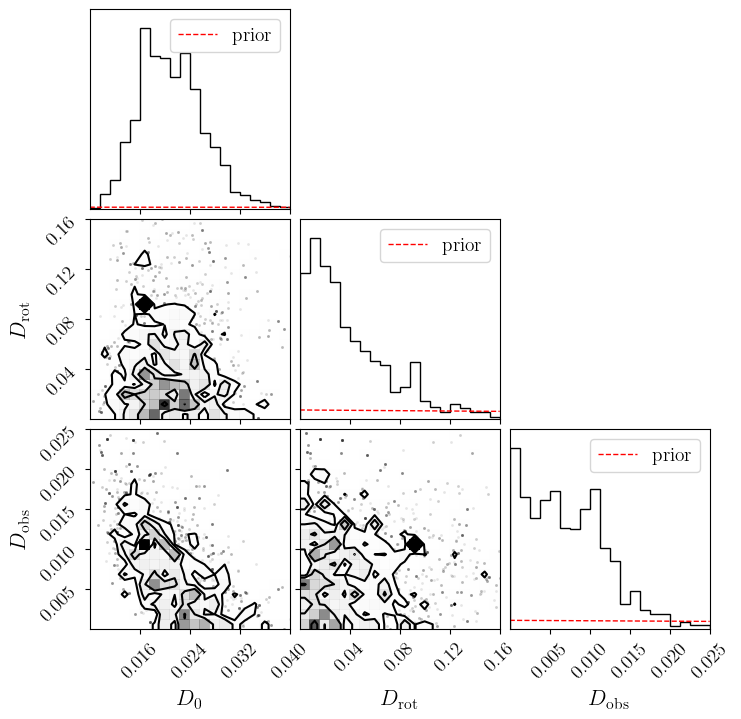

In [32]:
#particles.plotting_util.extended_corner(np.stack([my_alg.X.theta[p] for p in prior_dict.keys()]), prior_dict, my_alg.wgts.W)
# save results

axes_range = [[0.008, 0.04], [0, 0.16], [0,0.025]]

particles.plotting_util.extended_corner(samples_SMC2, prior_dict, my_alg.wgts.W, param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"], range=axes_range)
plt.savefig(f"corner_SMC2_data{length_data}.png", dpi=300)

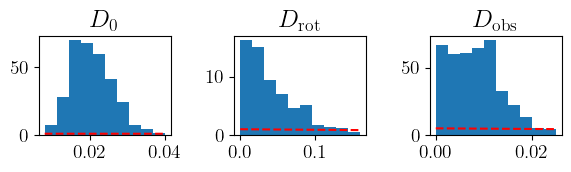

In [51]:
plt.figure(figsize=(6,2))
for n, p in enumerate(prior_dict.keys()):
    ra = axes_range[n]
    plt.subplot(1,3,n+1)
    plt.hist(samples_SMC2[n], range=ra, density=True)
    plot_ra = np.linspace(ra[0],ra[1],100)
    plt.plot(plot_ra, prior_dict[p].pdf(plot_ra), 'r--')
    plt.title(param_labels[n])
plt.tight_layout()    
plt.savefig(f"marginal_SMC2_data{length_data}.png", dpi=300)

In [34]:
my_pmmh = mcmc.PMMH(ssm_cls=ABM, fk_cls=rao_blackwell.Bootstrap_RaoBlackwell, prior=my_prior, data=ys, Nx=num_particles,  niter=20000, verbose=100)
my_pmmh.run()

Iteration 0, 2025-07-31 13:30:50.443758, D0=0.8460100695298249, Dobs=0.006178190339672836, Drot=2.3827387813850263
Iteration 200, 2025-07-31 13:34:10.448052, acc. rate=0.205, D0=0.007385883366914135, Dobs=0.04103246501899703, Drot=0.2777178165579167
Iteration 400, 2025-07-31 13:37:50.420932, acc. rate=0.215, D0=0.022161239975761585, Dobs=0.004630653313503155, Drot=0.06970308966675526
Iteration 600, 2025-07-31 13:40:42.166904, acc. rate=0.190, D0=0.02037241690765258, Dobs=0.003213707056208812, Drot=0.007999272454727287
Iteration 800, 2025-07-31 13:44:07.084144, acc. rate=0.217, D0=0.027021061973566178, Dobs=0.008162090861126426, Drot=0.006833778721870465
Iteration 1000, 2025-07-31 13:47:41.870777, acc. rate=0.235, D0=0.02123311636053849, Dobs=0.0042839960869124494, Drot=0.016196457576193736
Iteration 1200, 2025-07-31 13:50:48.409434, acc. rate=0.243, D0=0.02674609506049816, Dobs=0.002210880154279078, Drot=0.025481807366054567
Iteration 1400, 2025-07-31 13:53:48.292185, acc. rate=0.252, 

Iteration 12000, 2025-07-31 18:00:14.082738, acc. rate=0.238, D0=0.023360560378207412, Dobs=0.00016715448207634096, Drot=0.00860978954269762
Iteration 12200, 2025-07-31 18:04:27.951178, acc. rate=0.237, D0=0.01666089826571357, Dobs=0.005078257038120452, Drot=0.05966057307787198
Iteration 12400, 2025-07-31 18:09:57.923219, acc. rate=0.237, D0=0.02739829063226697, Dobs=0.0010787156380940076, Drot=0.00942881851243605
Iteration 12600, 2025-07-31 18:13:10.409616, acc. rate=0.235, D0=0.02300801327408368, Dobs=0.0012980414922907973, Drot=0.023346354871012706
Iteration 12800, 2025-07-31 18:18:57.639196, acc. rate=0.235, D0=0.02137739684143238, Dobs=0.008063820066316717, Drot=0.04428458140068772
Iteration 13000, 2025-07-31 18:24:11.364474, acc. rate=0.235, D0=0.01877942361214376, Dobs=0.0066793325564542365, Drot=0.051594690092850386
Iteration 13200, 2025-07-31 18:29:55.616146, acc. rate=0.235, D0=0.01661561317232984, Dobs=0.010061986502527008, Drot=0.05802403404575459
Iteration 13400, 2025-07-3

In [35]:
with open(f"result_PMMH_{length_data}.npy", 'wb') as f:
    np.save(f, np.stack([my_pmmh.chain.theta[p] for p in prior_dict.keys()]))

In [36]:
with open(f"result_PMMH_{length_data}.npy", 'rb') as f:
    samples_PMMH = np.load(f)

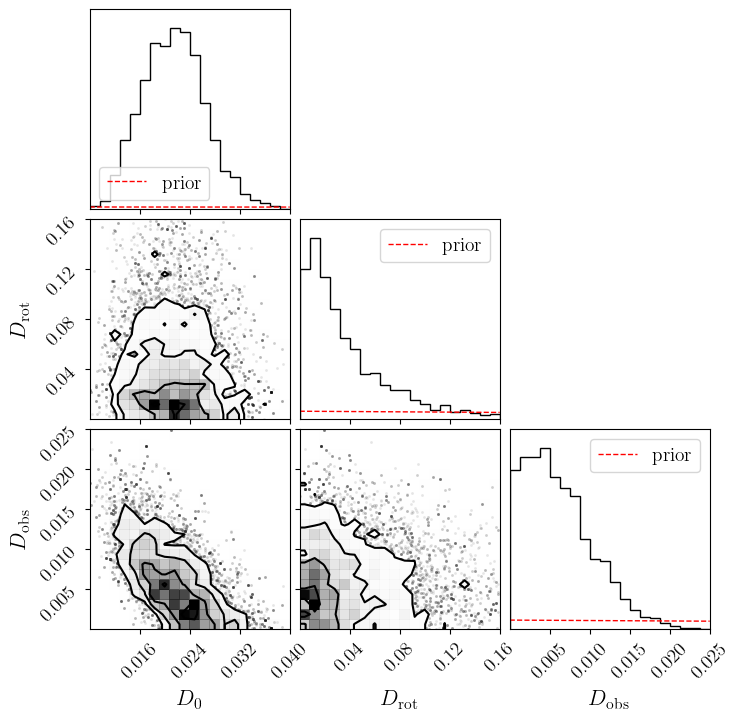

In [37]:


N_burnin = 2000
array_samples_burnin = samples_PMMH[:,N_burnin:]
plotting_util.extended_corner(array_samples_burnin, prior_dict, param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"], range=axes_range)
plt.savefig(f"corner_PMMH_data{length_data}.png", dpi=300)

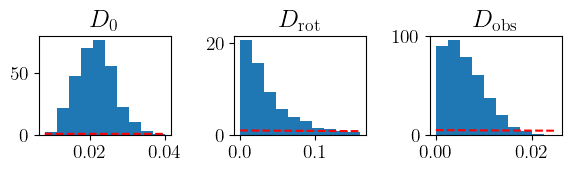

In [52]:
plt.figure(figsize=(6,2))
for n, p in enumerate(prior_dict.keys()):
    ra = axes_range[n]
    plt.subplot(1,3,n+1)
    plt.hist(array_samples_burnin[n], range=ra, density=True)
    plot_ra = np.linspace(ra[0],ra[1],100)
    plt.plot(plot_ra, prior_dict[p].pdf(plot_ra), 'r--')
    plt.title(param_labels[n])
plt.tight_layout()    
plt.savefig(f"marginal_PMMH_data{length_data}.png", dpi=300)